# Background

This notebook walks the user though the design and tuning of a neural network to predict the adsorption energetics of $\cdot{CH_3}$, $\cdot{OH}$, and $CO$ (several key intermediates in a variety of catalytic processes including $CO_2$ hydrogenation) to nanoparticles made of Cu, Ag, and Au. 

## Adsorption Energetics

Broadly, this notebook re-implements a recent adsorption model found by Dean et al and published in [Science Advances](https://advances.sciencemag.org/content/5/9/eaax5101.abstract). This work was motivated by the need to predict the adsorption energetics of molecular species to heterogeneous catalysts. Understanding this physical property is important, as catalytic activity is [often a function](https://en.wikipedia.org/wiki/Sabatier_principle) of the adsorption strength of key intermediates, and tuning a catalysts's adsorption strength can be a key part of optimizing its catalytic activity. Typically, one calculates adsorption energy by performing three separate Density-Functional Theory (DFT) calculations:

1. The adsorbate (for example, CO)
2. The catalyst (for example, a nanoparticle)
3. The adsorbed state (for example, CO adsorbed to a particular adsorption site on a nanoparticle)

The adsorption energy is then calculated as follows, where $E_{ads}$ is the adsorption energy, $E_{adsorbate}$ is the energy of the adsorbate (calculation #1 above), $E_{catalyst}$ is the energy of the catalyst (calculation #2 above), and $E_{adsorbate-catalyst}$ is the energy of the complex between the two (calculation #3 above):

$E_{ads} = E_{adsorbate-catalyst} - E_{adsorbate} - E_{catalyst}$

In simpler terms, this equations calculates the energy required to begin at the adsorbed state, and separate the adsorbate and catalyst at an infinite distance from one-another.

This can become computationally expensive, as it requires three different DFT calculations for one material. Hence, this motivates the model created by [Dean et al](https://advances.sciencemag.org/content/5/9/eaax5101.abstract), as the creation of a computationally-inexpensive method of predicting adsorption energetics can increase the throughput of catalyst screening, thus accelerating catalyst discovery.

## The Training Set

The training set consists of the adsorption energetics to sites on various nanoparticles made of copper, silver, and gold (metals which are commonly investigated for catalytic applications). Adsorbates investigated were $\cdot{CH_3}$, $\cdot{OH}$, and $CO$, which were chosen because of their relevance as intermediates in various catalytic cycles. Data was generated using [CP2K](https://www.cp2k.org/)'s implementation of DFT. A Double-Zeta Valence Polarized (DZVP) basis set was used in conjunction with the pseudopotentials of Goedecker, Teter, and Hutter (with a 500Ry cutoff) and the Perdew-Burke-Ernzerhof (PBE) functional. Overall, this results in a robust methodology which is generally good at capturing the adsorption interaction of catalytically-relevant species to transition metals.

## Descriptors Used

In the work, three desriptors were found: $CE_{local}$, $\mu_{adsorbate}$, and MADs. They were chosen for their rapid determination, either being tabulated or computationally-inexpensive to determine.

- $CE_{local}$ is a descriptor which represents the stability of the binding site. Specifically, if we consider a metal atom bound to a nanoparticle, $CE_{local}$ is equal to the sum of bond energies for every bond it forms with the cluster. For example, if atom A was bound to atoms B, C, and D in a nanoparticle, $CE_{local}$ would be equal to the sum of the A-B bond energy, the A-C bond energy, and the A-D bond energy. Implementation-wise, to avoid requiring DFT calculations, Dean et al utilized a variation of the [Bond-Centric Model](https://pubs.acs.org/doi/abs/10.1021/acs.nanolett.8b00670) (BCM) of nanoparticle stability, which enables the rapid prediction of bond energies in a metallic system.

- $\mu_{adsorbate}$ is the chemical potential of the adsorbate, which can be approximated under Hard/Soft Acid/Base (HSAB) theory via a first-order central differencing approximation using the Electron Affinity (EA) and Ionization Potential (IP) of the molecule. This results to the negative average of the IP and EA. For many relevant chemical species, the IP and EA area readily tabulated on resources such as the NIST WebBook or CRC Handbook of Chemistry.

- MADs functions as a descriptor of the intrinsic tendency of the <u>M</u>etal and <u>ADS</u>orbate to bind. It is the binding energy between the adsorbate and a single metal atom of the relevant metal type (for example, for CO adsorbing to Cu, it would be the binding strength of a single CO molecule adsorbing to a single atom of Cu). Although this is performed via DFT, there are few-enough atoms that this calculation is highly tractable. Moreover, because it is only performed once for a given adsorbate-metal pair, it does not present a bottleneck to a high-throughput screening approach.

## Neural Networks

In the original paper, a linear regression is found using the above descriptors with a 10-fold cross validated Root Mean Squared Error (RMSE) of 0.179 eV:

$E_{ads} \approx a*CE_{local} + b*\mu_{adsorbate} + c*MADs + d$

In this notebook, we replicate the results of this linear regression using a neural network. We proceed through a -step process:

1. We import the adsorption data along with the above descriptors descriptor (available in the supporting information of [the paper](https://advances.sciencemag.org/content/5/9/eaax5101.abstract))
2. We create a function to programatically create a neural network using TensorFlow
3. We optimze several neural network hyperparameters using Scikit-Learn's cross-validated grid search implementation
4. We train a final neural network using the tuned hyperparameters, and evaluate it by:
    a. Learning curves for the train / test set
    b. A parity plot of predicted versus ground-truth adsorption energy

# Setting Up

In [1]:
import random
import logging
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.model_selection
import subprocess
import tensorflow as tf
import IPython
from tensorflow.keras.layers import Dense, BatchNormalization, InputLayer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [2]:
# Random seeds for reproducibility
np.random.seed(1234)
random.seed(1234)

Next, we'll get everything into a Pandas dataframe.

In [3]:
# Load data into a Pandas dataframe for convenience
df = pd.read_csv("../assets/sci_adv_dean_data.csv", sep=",")
y_cols = ["PBE_BE_eV"]
x_cols = ["CE_Local_eV", "ChemPot_eV", "MADS_eV"]

# Split up into X/Y values, for convenience
train_x = df[x_cols]
train_y = df[y_cols]

# Display a friendly CSV of the data within Jupyter.
IPython.display.display(df)

,Morphology,N_Atoms,Element,CN,Adsorbate,BoundMetal,PBE_BE_eV,CE_Local_eV,ChemPot_eV,MADS_eV
0,Cube,172,Ag,3,CH3,Ag,-1.394010,-2.378249,-4.961500,-2.103302
1,Cube,172,Ag,5,CH3,Ag,-1.108635,-3.354383,-4.961500,-2.103302
2,Cube,172,Ag,8_1,CH3,Ag,-0.946148,-4.811101,-4.961500,-2.103302
3,Cube,172,Ag,8_2,CH3,Ag,-0.744214,-4.596331,-4.961500,-2.103302
4,Cube,172,Ag,8_3,CH3,Ag,-0.798119,-4.596331,-4.961500,-2.103302
...,...,...,...,...,...,...,...,...,...,...
157,Icosahedron,55,Cu,6,OH,Cu,-2.685197,-4.539619,-7.422335,-3.584923
158,Icosahedron,55,Cu,8,OH,Cu,-2.619955,-5.678627,-7.422335,-3.584923
159,Icosahedron,147,Cu,6,OH,Cu,-2.953359,-4.539619,-7.422335,-3.584923
160,Icosahedron,147,Cu,8,OH,Cu,-2.717343,-5.582781,-7.422335,-3.584923


## Hyperparameter Optimization

The "Hyperparameter Optimization" step of a typical ML process involves tuning various parts of the machine learning implementation. For example, in a neural network, one hyperparameter is the so-called "architecture" of the network. In other words, where the different neurons are, how many neurons there are, the activation functions used in each neuron, etc. In our case, to keep things simple, we only tune the depth and width of the network.

Next, we create a function to automatically create a TF feedforward neural network with a given width an depth. We then use this function alongside TF's wrapper for the Sklearn regressor API to produce a build function for use in the grid search.

In [4]:
def create_model(hidden_layers_width: int, hidden_layers_depth: int) -> tf.keras.Sequential:
    """
    Function to programatically create a standard feedforward neural network with a given architecture.
    
    Args:
        hidden_layers_width (int): How many neurons are inside each layer.
        hidden_layers_depth (int): How many hidden layers the neural network has.
        
    Returns:
        A keras Sequential model object.
    """
    
    # Initialize the model object
    model = tf.keras.Sequential()
    
    # Input layer of the model
    model.add(InputLayer(input_shape=len(x_cols),
                         name="Input_Layer")
             )
    
    # Batch normalization is useful, normalizing the data before it continues deeper into the network.
    model.add(BatchNormalization(name="Batch_Normalization"))
    
    # Hidden layers
    # These are typically important for ensuring the network has enough freedom to tackle the regression problem.
    # A neural network without a hidden layer is typically called a "Perceptron," and is very limited in the types of data it can model.
    for layer in range(hidden_layers_depth):
        model.add(Dense(hidden_layers_width,
                        activation="relu",
                        name=f"Hidden_Layer_{layer+1}")
                 )
        
    # Output layer
    # Because this is a regression problem, here we use linear activation (e.g. summing every input plus the activation)
    model.add(Dense(1, # Only one output neuron
                    activation="linear",
                    name="Output_Layer")
             )
    
    # Compile the model object and return it
    model.compile(loss="mse")
    return model

# TensorFlow / Keras comes with a convenient wrapper to facilitate its integration it the Scikit-Learn framework.
nn_model = KerasRegressor(build_fn=create_model,
                          verbose=0,    # Ranges from 0-2; how much output the model should print while it is training.
                          epochs=256,   # How many epocs (number of complete passes over the training set) to train the network.
                          batch_size=16 # How many examples to consider at a time (See https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a for a detailed explanation)
                          )

We now conduct a grid search over several possible architectures.

In [5]:
# Number of folds for cross-validation
folds = 5

# How many threads to use for the grid search
n_threads = 4

# Hidden layer widths to check
hidden_layer_widths = [3]

# Depths to check
hidden_layer_depths = [0, 1, 2, 4, 8]

# Put together the dictionary of tuning parameters, for our GridSearchCV later on
tuning_parameters = {"hidden_layers_width": hidden_layer_widths,
                     "hidden_layers_depth": hidden_layer_depths}

In [6]:
print(f"Training on {len(train_x)} samples across {len(train_x.columns)} features")
print(f"{folds}-fold CV")

# Set up the grid
grid = sklearn.model_selection.GridSearchCV(estimator=nn_model,               # SKlearn Regressor/Classifier object to tune. This object gets repeatedly trained.
                                            param_grid=tuning_parameters,     # Which parameters to check (in our case, width and depth). All possibilit combos will be checked.
                                            scoring="neg_mean_squared_error", # How to rank each combination of hyperparameters (here, we use RMSE). Note that GridSearchCV tries to minimize the scoring metric, hence we use the negative version of RMSE.
                                            verbose=1,                        # Ranges from 1-3. How much information to print to the screen during the grid search.
                                            cv=folds,                         # Controls the number of folds to be used in cross-validation.
                                            n_jobs=n_threads                  # How many models are to be trained simultaneously.
                                            )

# Ensure TensorFlow stays silent during training ( to avoid flooding the console with warning messages, since TF occasionally uses depreciated features of NumPy )
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Fit the grid
grid.fit(X=train_x, y=train_y)

Training on 162 samples across 3 features
5-fold CV
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   18.9s finished


GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x175e20400>,
             n_jobs=4,
             param_grid={'hidden_layers_depth': [0, 1, 2, 4, 8],
                         'hidden_layers_width': [3]},
             scoring='neg_mean_squared_error', verbose=1)

Now, let's print out some information about the best architecture found:

RMSE = 0.254

Best parameters are:
	hidden_layers_depth : 0
	hidden_layers_width : 3

Detailed Information:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Batch_Normalization (BatchNo (None, 3)                 12        
_________________________________________________________________
Output_Layer (Dense)         (None, 1)                 4         
Total params: 16
Trainable params: 10
Non-trainable params: 6
_________________________________________________________________
None

Architecture:


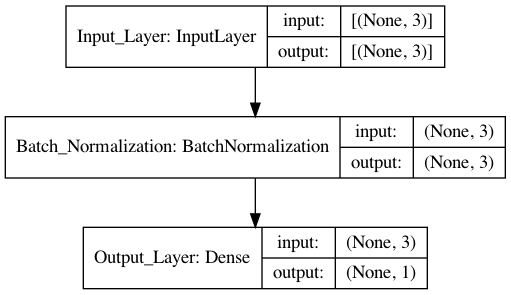

In [7]:
# Print the RMSE
rmse = np.round(np.sqrt(abs(grid.best_score_)),3)
print(f"RMSE = {rmse}")

# Print the best set of hyperparameters which were found
best_params = grid.best_params_
print("\nBest parameters are:")
for key, value in best_params.items():
    print(f"\t{key} : {value}")

# Using this set of hyperparameters, compile the final form of the model.
best_model = create_model(hidden_layers_width=best_params["hidden_layers_width"],
                          hidden_layers_depth=best_params["hidden_layers_depth"])

# Print out detailed information regarding the neural network architecture.
#     "Output Shape" refers to the shape of the vector/tensor the given layer sends to the next.
#     "Param #" refers to the number of parameters involved in the creation of that layer (i.e. weights, biases, etc). This is analogous to the concept of "Degrees of Freedom" in least-squares regression.
print("\nDetailed Information:")
print(best_model.summary())

# Draw a graph of the architecture below (this is a useful feature for drafting paper/presentation figures!)
print("\nArchitecture:")
# GraphViz (specifically, its executable named "dot") does need to be in the system path for this to work. Here, we check that it's installed.
try:
    subprocess.call(['dot', '-v'])
    dot_exists = True
except FileNotFoundError:
    dot_exists = False
# Now that we know whether it exists, we might draw the network.
# Note that this will create a new file named "architecture.png" (or whatever arch_filename is assigned to) in the current working directory
if dot_exists:
    arch_filename = "architecture.png"
    tf.keras.utils.plot_model(best_model, show_shapes=True, to_file=arch_filename)
    image = IPython.display.Image(filename=arch_filename)
    IPython.display.display(image)
else:
    # If GraphViz is not in the system path, we'll error out if we try to use it.
    print("dot is not found in the System path, but was needed to draw the architecture.")

## Final Training

Now that we have identified a good model architecture, we train it.

In [8]:
# Train the final network
history = best_model.fit(train_x, train_y,                      # Training Data
                         epochs=100000,                         # Maximum number of epochs to use. Note that here, we use the EarlyStopping callback to halt training once the error has stopped improving.
                         batch_size=16,                         # Number of examples to consider simultaneously in the approximation of the error gradient. See: https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a
                         verbose=0,                             # How much to print to console during training. Ranges from 0-2.
                         validation_split=0.1,                  # The percentage of data to leave out as a validation set (in this case, 0.1 leaves out 10%, and trains on the remaining 90%).
                         callbacks=[                            # "Callbacks" are special helper-functions that Keras can use during training. See: https://keras.io/api/callbacks/
                             tf.keras.callbacks.EarlyStopping(  # EarlyStopping halts the training process once the quality of the neural network's predictions has stopped improving.
                                 monitor="val_loss",            # The parameter we're monitoring for improvement. In this case, it's loss of the validation data we've left out of the training set (controlled by validation_split above).
                                 min_delta=0,                   # The minimum amount of change in the error gradient for us to consider it an improvement. In this case, to simplify things we just check whether any improvement has been made at all.
                                 patience=50,                   # How many epochs are allowed to pass without improvement before the network's training is stopped.
                                 mode="min",                    # Whether we are looking for loss to increase or decrease. In our case, we want it to decrease.
                                 restore_best_weights=True)     # This option allows us to restore the parameters which yielded the best model found during the training process.
                         ]
                         ).history # History objects are created when a Keras neural network gets fit.

## Final Evaluation

Now that we have a trained model, we'll plot its learning curve and create a parity plot.

In [9]:
# Parameters for PyPlot. Controls how large the figures are when printed to the screen or saved.
plt.rcParams['figure.figsize'] = 5,5
plt.rcParams['figure.dpi'] = 200

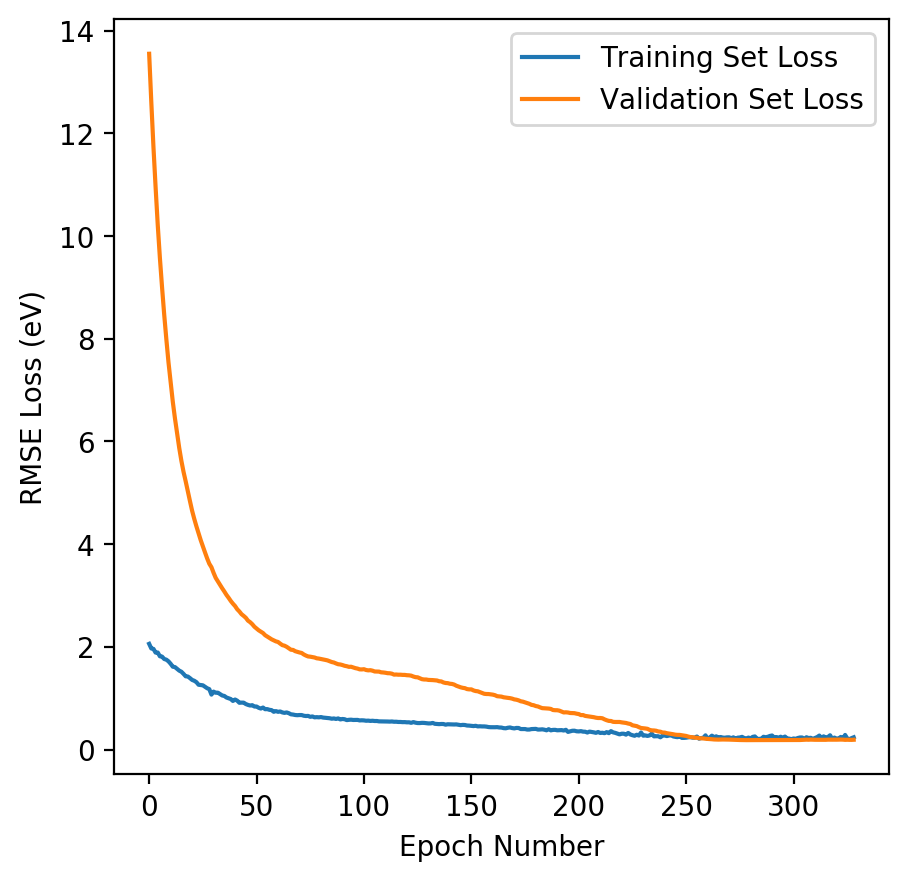

In [10]:
loss = np.sqrt(history["loss"]) # Loss over time of the training set
val_loss = np.sqrt(history["val_loss"]) # Loss over time of the validation set

# Plot the training history
plt.plot(loss, label="Training Set Loss")
plt.plot(val_loss, label="Validation Set Loss")

# Make the plot look a bit better, add labels
plt.legend()
plt.ylabel("RMSE Loss (eV)")
plt.xlabel("Epoch Number")

# Save the plot to disk
fig = plt.gcf()
fig.savefig("learning_curve.png")

# Show the plot to the user
plt.show()
plt.close()

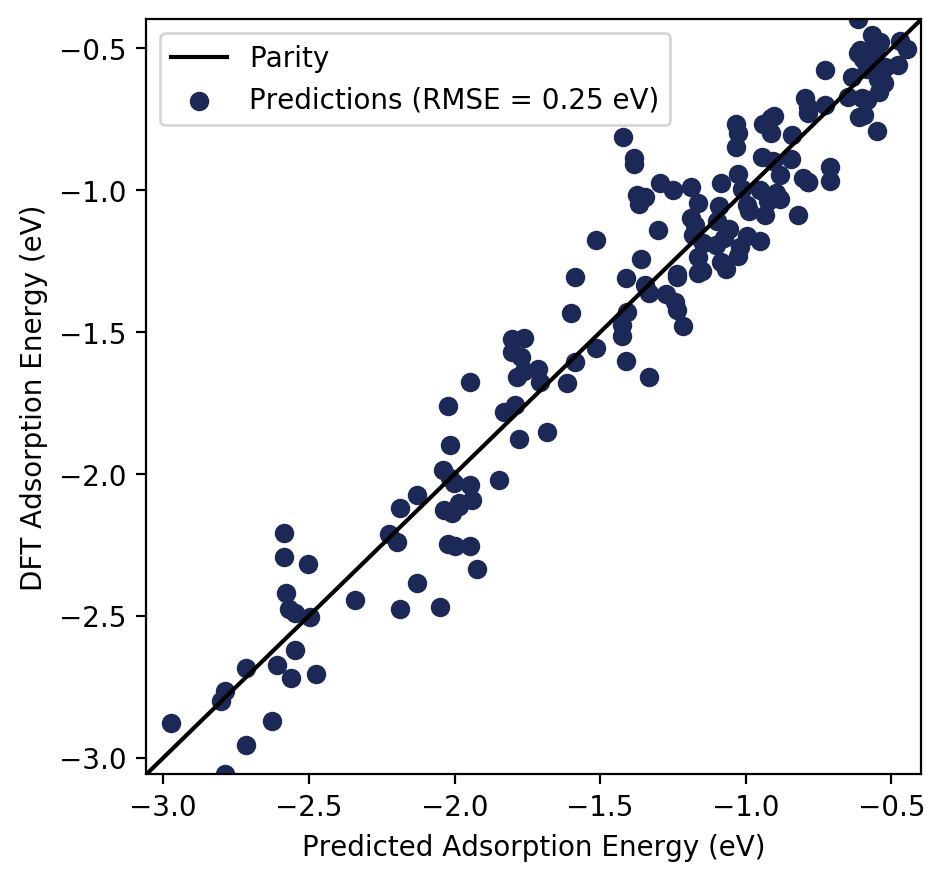

In [11]:
# Get predictions for every row in the dataset
df["predicted_adsorption_eV"] = best_model.predict(train_x)

# Make a parity plot. That is, plot the predictions of the model versus the training set values (which are from DFT)
plt.scatter(x=df["predicted_adsorption_eV"], y=train_y,
            label=f"Predictions (RMSE = {np.round(rmse, 2)} eV)",
            c="#1c2957")

# To make the plot have the same dimensions in X and Y, find the min and max in each dimension.
lims_min = min(min(df["predicted_adsorption_eV"]),
               float(train_y.min())
               )
lims_max = max(max(df["predicted_adsorption_eV"]),
                float(train_y.max())
               )
lims = (lims_min, lims_max)

# Set the limits to ensure the plot is square
plt.xlim(lims)
plt.ylim(lims)

# Plot a line along y=x as a guide to the eye of what perfect parity looks like
plt.plot([lims[0], lims[1]],
         [lims[0], lims[1]],
         label="Parity", c="black")

# Make the plot look a bit better, add labels
plt.legend()
plt.ylabel("DFT Adsorption Energy (eV)")
plt.xlabel("Predicted Adsorption Energy (eV)")

# Save the plot to disk
fig = plt.gcf()
fig.savefig("parity.png")

# Show the plot to the user
plt.show()
plt.close()

## Save Model

And last, we will save the final trained model.

In [12]:
# Save the final model to disk
# This is a very convenient feature of Keras, as the model could then be loaded and used to predict new values later-on, without needing to re-train.
# For a model that's simple like ours, avoiding retraining isn't a huge concern, but for larger networks that might be resource-intensive to train, this could be an important final step.
print(best_params)
best_model.save("best_model.mdl")

{'hidden_layers_depth': 0, 'hidden_layers_width': 3}
